## Group D
[Juan Bohórquez](https://github.com/JuanBoho)
_______

Apply MapReduce to group D data in the StackOverflow's dataset

#### Index
1. [Setup](#setup)
2. [Data Extraction](#data-extraction)
3. [Top 10 Posts Without Accepted Answers](#3-top-10-answers-in-posts-without-accepted-answers)
4. [Relationship between the number of answers in a post and it's score.](#4-relationship-between-the-number-of-answers-in-a-post-and-its-score)
5. [Top 10 questions with longest activity time](#5-top-10-questions-with-longest-activity-time)
6. [Output Analysis](#6-output-analysis)


### Setup

In [313]:
import pathlib
import xml.etree.ElementTree as ET
import logging
from lib.chunckify import chunckify
from functools import reduce

import pandas as pd

In [314]:
# Logs config
logging.basicConfig(format='%(asctime)s-%(levelname)s-%(message)s', datefmt='%Y-%m-%d')
logger = logging.getLogger(__name__)

__file__ = "analisis_grupo_d.ipynb"  # interactive python sol to path_p

# Path sol
path_p = (pathlib.Path(__file__).parent.absolute())


### Data Extraction

In [315]:
def extract_data(path, filename):

    """ Data extraction from xml files:
        - path: xml location
        - filename : xml filename 
    """
    
    file_path = f'{path}/dataset/Stack Overflow 11-2010/112010 Meta Stack Overflow/{filename}'

    try:
        tree = ET.parse(r'{}'.format(file_path))
        root = tree.getroot()
    except FileNotFoundError as e:
        logger.error(f'Error en path: {e}')
        raise e
    
    except Exception as e:
        logger.error(e)
        raise e
    
    return root


full_data = extract_data(path_p, 'posts.xml')


In [316]:
# Chunkify data
data_chunks = chunckify(full_data, 50)

##### Quick file exploration

In [317]:
# Available data
for row in full_data[:1]:
    xx = row.attrib.keys()
    print([x for x in xx])

['Id', 'PostTypeId', 'AcceptedAnswerId', 'CreationDate', 'Score', 'ViewCount', 'Body', 'OwnerUserId', 'LastEditorUserId', 'LastEditorDisplayName', 'LastEditDate', 'LastActivityDate', 'Title', 'Tags', 'AnswerCount', 'CommentCount', 'FavoriteCount']


In [318]:
# How a single posts data lookslike
for row in full_data[:1]:
    xx = row.attrib.keys()
    for x in xx:
        print(x, ":", row.attrib[x])

Id : 1
PostTypeId : 1
AcceptedAnswerId : 8
CreationDate : 2009-06-28T07:14:29.363
Score : 57
ViewCount : 1836
Body : <p>Now that we have meta.stackoverflow.com, should we continue using uservoice.com?</p>

<p>The only requirement for participation here is that you have an existing stackoverflow / serverfault / superuser account -- but you can be a brand new user, so anonymous participation is allowed.</p>

<p>It seems that questions tagged "bug" or "feature" could be voted on and commented in a fashion very similar to what uservoice already offers.</p>

<p>Some people wanted to <a href="http://stackoverflow.uservoice.com/pages/1722-general/suggestions/193243-move-from-uv-to-getsatisfaction" rel="nofollow">move to GetSatisfaction</a>, but I wasn't happy with that service.</p>

OwnerUserId : 1
LastEditorUserId : 56285
LastEditorDisplayName : 
LastEditDate : 2009-08-30T09:13:00.970
LastActivityDate : 2009-08-30T09:13:00.970
Title : Should meta.stackoverflow.com replace uservoice.com?
Tags

### 3. Top 10 answers in posts without accepted answers

Steps:
1. Look for posts with unaccepted answers
2. None values filter
3. In those posts look for answercount attribute
4. None values filter again.
5. Top ten number of answers in posts without accepted answers

In [319]:
# Map Functions

def post_unaccepeted_ans(data):
    """ Map: Get post with unaccepted answers. 
        Return None value if data do have an accepted answer
    """
    post_type = data.attrib['PostTypeId']
    
    if post_type == '1':
        try:
            accepted_ans = data.attrib['AcceptedAnswerId']
        except:
            return data
        
        return None


def post_ans_count(data):

    """ Map: Look for AnswerCount attribute (number of answers), if True return a tuple (post_id, answercount)
    """
    
    post_id = data.attrib['Id']
    
    try:
        ans_count = data.attrib['AnswerCount']
        ans_count = int(ans_count)
    except:
        return
    
    
    return data, ans_count


# Reduce
def top_ans_count(data1,data2):
    """ Reduce: return the top 10 highest values in answercount
    """
    top = data1 + data2
    top = sorted(top, key = lambda x: x[1], reverse = True)

    return top[:10] if len(top) > 10 else top


In [320]:
# MapReduce function
def mapper(data):
    """
    In: Chunk
    Out: List of tuples (post_id, post_answer_count)

    Map each post:
        1. Those with unaccepted answers
        2. None values filter
        3. Those with answercount attribute
        4. None values filter
    """
    post_sin_respuestas = list(map(post_unaccepeted_ans,data))
    post_sin_respuestas = list(filter(lambda x : x != None, post_sin_respuestas))
    post_id_count_respuestas = list(map(post_ans_count, post_sin_respuestas))
    post_id_count_respuestas = list(filter(lambda x : x != None, post_id_count_respuestas))

    return post_id_count_respuestas


In [321]:
mapped = list(map(mapper,data_chunks))  # Map
reduced = reduce(top_ans_count,mapped)  # Reduce

#### Results

In [322]:
# Results for humans

def show_top_answers(reduced):
    """ Map reduce to dictionarie """
    top_ten = {'Id':[], 'AnswerCount':[]}
    
    for post, num_ans in reduced:
        post_id = post.attrib['Id']
        top_ten['Id'].append(post_id) 
        top_ten['AnswerCount'].append(num_ans)
    
    return top_ten

def top_to_df(dictionarie):
    """ Map Reduce dictionarie to pandas Dataframe """
    dict = show_top_answers(dictionarie)
    df = pd.DataFrame.from_dict(dict)
    df['Top'] = [i for i in range(1,11)]
    df = df.reindex(columns=['Top', 'Id', 'AnswerCount'])

    return df

df_top_ans = top_to_df(reduced)
df_top_ans

,Top,Id,AnswerCount
0,1,102,121
1,2,34181,94
2,3,31913,90
3,4,5097,77
4,5,11115,70
5,6,12259,70
6,7,9953,68
7,8,10299,64
8,9,3086,63
9,10,9508,63


In [323]:
# Results to csv
df_top_ans.to_csv('output/top_ten_ans_d.csv', index=False)

### 4. Relationship between the number of answers in a post and its score.

Steps:
1. Look for posts with 'AnswerCount' attribute
2. None values filter
3. For those posts extract answers, score and id
4. Calculate ratio for each resulting post in 3.

In [324]:
# Map functions

def map_one(data):
    try:
        answers = data.attrib['AnswerCount']
    except:
        return
    
    return data

def map_two(data):
    answers = data.attrib['AnswerCount']
    id = data.attrib['Id']
    try:
        score = data.attrib['Score']
    except:
        return
    
    if score: return answers, score, id

def ratio(data):
    id = data[2]
    ans = int(data[0])
    score = int(data[1])

    ratio = ans/(score, 1)[score == 0]  # avoid zero division

    return id,ans,score, round(ratio,2)

In [325]:
# Map function

def mapper_two(data):
    map_one_lst = list(map(map_one, data))
    map_one_lst = list(filter(lambda x: x != None, map_one_lst))
    map_two_lst = list(map(map_two, map_one_lst))
    ratio_lst = list(map(ratio,map_two_lst))

    return ratio_lst


In [326]:
data_chunks = chunckify(full_data, 50)
mapped_two = list(map(mapper_two,data_chunks))

#### Results

In [327]:
# Results as df

def show_ratios(mapped_list):
    """ Map reduce to dictionarie """
    ratios = {'Id':[], 'AnswerCount':[], 'Score':[], 'Ratio':[]}
    
    for chunk in mapped_list:
        for post_id, ans, score, ratio in chunk:
            ratios['Id'].append(post_id)
            ratios['AnswerCount'].append(ans)
            ratios['Score'].append(score)
            ratios['Ratio'].append(ratio)
    
    return ratios

def ratios_to_df(dictionarie):
    """ Map Reduce dictionarie to pandas Dataframe """
    dict = show_ratios(dictionarie)
    df = pd.DataFrame.from_dict(dict)

    return df

df_ratios = ratios_to_df(mapped_two)
df_ratios


,Id,AnswerCount,Score,Ratio
0,1,13,57,0.23
1,6,4,5,0.80
2,9,4,3,1.33
3,10,9,8,1.12
4,11,2,3,0.67
...,...,...,...,...
13941,69056,2,0,2.00
13942,69060,1,7,0.14
13943,69063,31,49,0.63
13944,69076,1,1,1.00


In [328]:
# Results to csv
df_ratios.to_csv('output/ratios_d.csv', index=False)

### 5. Top 10 questions with longest activity time

Steps: 
1. Look for posts marked as questions
2. None values filter
3. In those posts look for 'CreationData' and 'ClosedDate' or 'LastActivityDate' and calculate days between them.
4. Top ten post with longest activity time


In [329]:
# extra lib
from datetime import datetime

# Map functions
def task_map_one(data):
    """ Map: Get post if categorized as question. 
    """
    post_type = data.attrib['PostTypeId']
    
    if post_type == '1':
        return data

   
def task_map_two(data):
    """ Look for 'CreationDate' and 'ClosedDate' attributes in post (if last one not in data looks for 'LastActivityDate').
        Calculate Activity time in days 
        return 
    """
    try:
        closed_date = data.attrib['ClosedDate']
    except:
        try: 
            closed_date = data.attrib['LastActivityDate'] 
        except:
            return

    init_date = data.attrib['CreationDate']
    init_date = datetime.strptime(init_date, '%Y-%m-%dT%H:%M:%S.%f')
    closed_date = datetime.strptime(closed_date, '%Y-%m-%dT%H:%M:%S.%f')

    delta = closed_date - init_date
    delta = int(delta.total_seconds() / 60) / 1440 # delta in days

    return data, round(delta,4)


# Reduce function
def top_ten(data1,data2):
    """ Reduce: return the top 10 post with longest activity time
    """
    top = data1 + data2
    top = sorted(top, key = lambda x: x[1], reverse = True)

    return top[:10] if len(top) > 10 else top



In [330]:
def mapper_three(data):
    map_one_lst = list(map(task_map_one, data))
    map_one_lst = list(filter(lambda x: x != None, map_one_lst))
    map_two_lst = list(map(task_map_two, map_one_lst))

    return map_two_lst

In [331]:
data_chunks = chunckify(full_data, 50)  # Chunkify data
mapped_three = list(map(mapper_three,data_chunks))  # Map

reduced_two = reduce(top_ten, mapped_three)

#### Results

In [332]:
# Results as df

def show_top_time(reduced):
    """ Map reduce to dictionarie """
    top_ten = {'Id':[], 'Activity_Days':[]}
    
    for post, days in reduced:
        post_id = post.attrib['Id']
        top_ten['Id'].append(post_id) 
        top_ten['Activity_Days'].append(days)
    
    return top_ten

def top_ten_to_df(dictionarie):
    """ Map Reduce dictionarie to pandas Dataframe """
    dict = show_top_time(dictionarie)
    df = pd.DataFrame.from_dict(dict)
    df['Top'] = [i for i in range(1,11)]
    df = df.reindex(columns=['Top', 'Id', 'Activity_Days'])

    return df

df_top_time = top_ten_to_df(reduced_two)
df_top_time

,Top,Id,Activity_Days
0,1,9508,806.8250
1,2,7931,802.4528
2,3,12362,785.6215
3,4,7046,779.4312
4,5,11602,774.0431
5,6,14656,770.9951
6,7,19470,769.2021
7,8,10582,763.2660
8,9,17853,762.6132
9,10,8211,760.9576


In [333]:
# Results to csv
df_top_time.to_csv('output/top_ten_time_d.csv', index=False)

### 6. Output Analysis

In [334]:
# Extra libraries
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

In [335]:
# Reading Ouputs csv as df
top_ten_ans_df = pd.read_csv("output/top_ten_ans_d.csv")  # Task 1 output
top_ten_time_df = pd.read_csv("output/top_ten_time_d.csv")  # Task 2 output
ratios_df = pd.read_csv("output/ratios_d.csv") # Task 3 Output

In [336]:
# Default Styles for Plots

color_a = '#7a7a7a'  # label, markers, tick, title color
color_b = '#131313'  # background color


#### Top 10 post without Accepted Answers

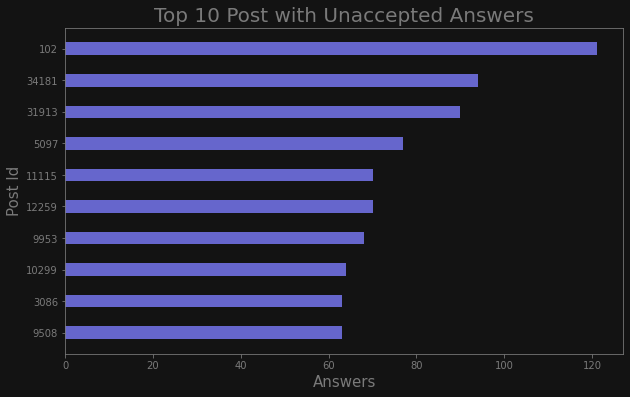

In [337]:
fig, ax = plt.subplots(figsize=(10, 6), facecolor=color_b)

posts = top_ten_ans_df['Id'] 
posts_ = np.arange(len(posts))
answers = top_ten_ans_df['AnswerCount']

ax.barh(posts_, answers, height=0.4, align='center', color='#6666cc')

ax.set_yticks(posts_, labels=posts)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Answers', fontsize=15)
ax.set_ylabel('Post Id', fontsize=15)
ax.set_title('Top 10 Post with Unaccepted Answers', fontsize=20)

ax.title.set_color(color_a)
ax.set_facecolor(color_b)
ax.spines[:].set_color(color_a)
ax.xaxis.label.set_color(color_a)
ax.yaxis.label.set_color(color_a)
ax.tick_params(axis='x', colors=color_a)
ax.tick_params(axis='y', colors=color_a)


plt.show()

#### Top 10 Questions with Longest Activity Time

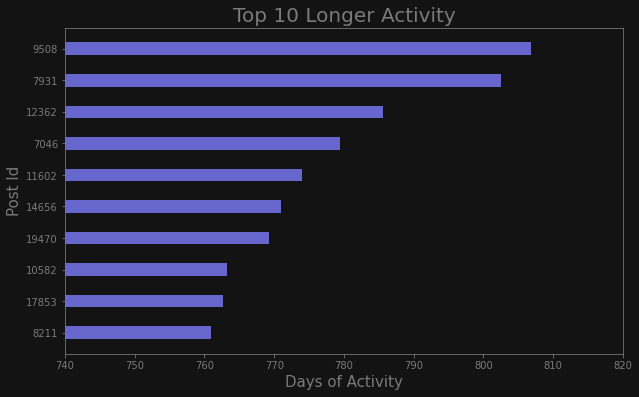

In [338]:
fig, ax = plt.subplots(figsize=(10, 6), facecolor=color_b)

posts = top_ten_time_df['Id']
posts_ = np.arange(len(posts))
time = top_ten_time_df['Activity_Days']

ax.barh(posts_, time, height=0.4, align='center', color='#6666cc')

plt.xlim([740,820]) # reduce x axis spectrum to 740 to 820 days (better viz)
ax.set_yticks(posts_, labels=posts)
ax.invert_yaxis()
ax.set_xlabel('Days of Activity', fontsize=15)
ax.set_ylabel('Post Id', fontsize=15)
ax.set_title('Top 10 Longer Activity', fontsize=20)

ax.title.set_color(color_a)
ax.set_facecolor(color_b)
ax.spines[:].set_color(color_a)
ax.xaxis.label.set_color(color_a)
ax.yaxis.label.set_color(color_a)
ax.tick_params(axis='x', colors=color_a)
ax.tick_params(axis='y', colors=color_a)


plt.show()

#### Relationship Between Answers and Score

<AxesSubplot:ylabel='Frequency'>

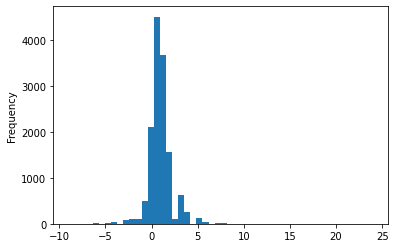

In [339]:
# Quick look at the data
ratios_df['Ratio'].plot.hist(bins=50)

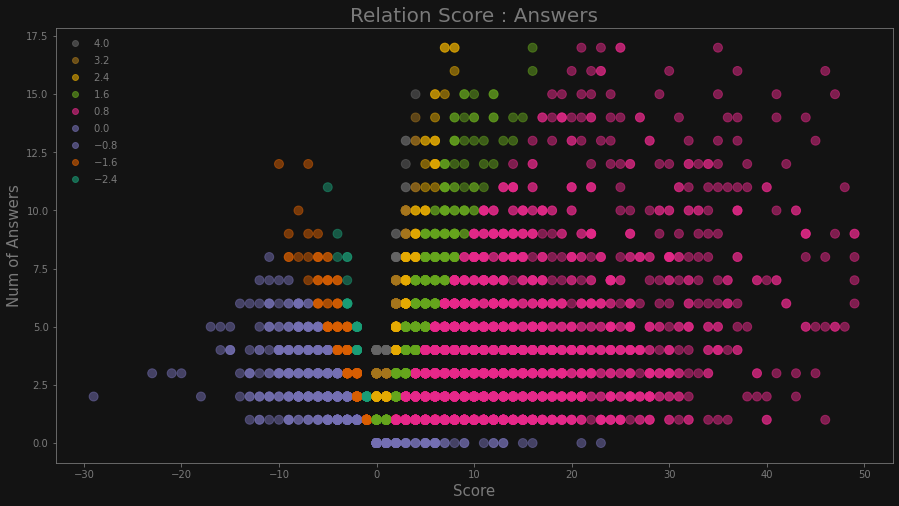

In [340]:
# 'Clean' outliers for friendlier plot (Standarization)
ratios_df = ratios_df[(np.abs(stats.zscore(ratios_df)) < 3).all(axis=1)]

# Series to numpy array
ratios = np.array(ratios_df['Ratio'].to_list())
answers = np.array(ratios_df['AnswerCount'].to_list())
scores = np.array(ratios_df['Score'].to_list())


# Scatter Plot
fig, ax = plt.subplots(figsize=(15, 8), facecolor=color_b)
scatter = ax.scatter(scores, answers, c=ratios, s=80, alpha=0.5, cmap='Dark2')

# Plot styling
ax.set_facecolor(color_b)
ax.set_xlabel('Score', fontsize=15)
ax.set_ylabel('Num of Answers', fontsize=15)
ax.set_title('Relation Score : Answers', fontsize=20)
ax.title.set_color(color_a)

ax.spines[:].set_color(color_a)
ax.xaxis.label.set_color(color_a)
ax.yaxis.label.set_color(color_a)
ax.tick_params(axis='x', colors=color_a)
ax.tick_params(axis='y', colors=color_a)
ax.grid(False)
handles, labels = scatter.legend_elements(prop="colors", alpha=0.6)
legend2 = ax.legend(handles[::-1], labels[::-1], loc="upper left", labelcolor=color_a, facecolor=color_b, frameon=False)


plt.show()